<a href="https://colab.research.google.com/github/Oanh0305/CSCA-5642/blob/main/NLP_Disaster_Tweets_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nlp-getting-started:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F17777%2F869809%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240612%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240612T051948Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da7e3f61fc0f512f991432aa09ea3dedb2143ef589f2fd69d3258cd459fd550b28330808ee6ed56c8e976e4c0564ac9d86801bb509afd2db4787af8c27b67177bf71f856697e411655b3f7e412caeca6c4adb27f52b6f4a357c880761db956a3489160b31f33bad83399d2f50abfbcc915db9609d2c528c8e076285b6a1da49e15a9ffb0c365c418a7d8013be96d3982965d2f3c979c20090fd5b1d2c455c8d2dbe94f3fffaccdab7fe35310a852781ce8773ad50f42847a8003da0eb889612915b622c764b1c54a3a7b036673961f08bd7af9ae96f07a74ae381867d7a160e641129a9a50dd8bc934c99c0c290e5748b3699e9d47cb215249590e64d695f0958'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 607343 bytes downloaded
Downloaded and uncompressed: nlp-getting-started
Data source import complete.


# NLP Disaster Tweets

## 1. Description of the problem and data

In this problem, the objective is to create a machine learning model that can discern between tweets discussing actual disasters and those that do not. We have a dataset containing 10,000 tweets that have been meticulously classified for this purpose.

In this notebook, I will:

* Load the Disaster Tweets
* Explore the dataset
* Preprocess the data
* Buil and train NLP model
* Generate the submission file

In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [11]:

import seaborn as sns
import matplotlib.pyplot as plt

import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS


from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer , WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding , LSTM, Dropout

from tensorflow.keras.utils import plot_model

from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings



<function warnings.filterwarnings(action, message='', category=<class 'Warning'>, module='', lineno=0, append=False)>

## 2. Exploratory Data Analysis (EDA)

### Read train data

In [12]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')



In [13]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
train_data.shape

(7613, 5)

### Analysis and Visualisation of Target of train_data

In [15]:
train_data['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<ipython-input-16-087d6f04bd69>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data = train_data, palette = colors)


Text(0.5, 1.0, 'Target Distributions \n (0: Non Disaster || 1: Disaster)')

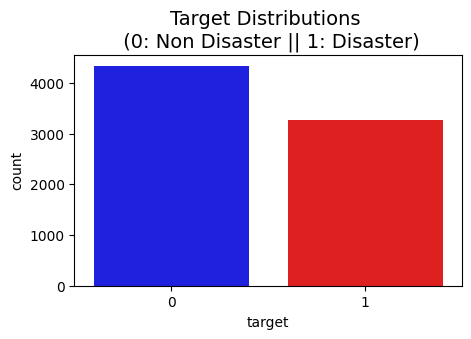

In [16]:
plt.figure(figsize =(5,3))
colors = ["blue", "red"]
sns.countplot(x='target', data = train_data, palette = colors)
plt.title('Target Distributions \n (0: Non Disaster || 1: Disaster)', fontsize =14)


### Text preprocessing: Removing Stopwords

In [17]:
nltk.download('stopwords')
def remove_stopword(text):
  removed_stopword = [word for word in text.split() if word.lower() not in stopwords.words('english')]
  return removed_stopword


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
train_data['cleaned_text'] = train_data['text'].apply(remove_stopword)

In [19]:
train_data.head()

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[Deeds, Reason, #earthquake, May, ALLAH, Forgi..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[Forest, fire, near, La, Ronge, Sask., Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[residents, asked, 'shelter, place', notified,..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, Ruby, #Alaska, smoke, #wild..."


In [20]:
 def count_words(x):
    return len(x.split())


train_data["num_words"] = train_data["text"].apply(count_words)

In [21]:
train_data.head()

,id,keyword,location,text,target,cleaned_text,num_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[Deeds, Reason, #earthquake, May, ALLAH, Forgi...",13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[Forest, fire, near, La, Ronge, Sask., Canada]",7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[residents, asked, 'shelter, place', notified,...",22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati...",8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, Ruby, #Alaska, smoke, #wild...",16


### Bag of words

In [22]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['cleaned_text'].values)
X = tokenizer.texts_to_sequences(train_data['cleaned_text'].values)
X = pad_sequences(X)

In [23]:
X.shape

(7613, 24)

## 3. Model Using LSTM

In [24]:
y = train_data['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 41)

In [25]:
embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.4))
model.add(Dense(1, activation = 'sigmoid'))
adam = optimizers.Adam(learning_rate =0.002)
model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 32)            96000     
                                                                 
 dropout (Dropout)           (None, 24, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 104353 (407.63 KB)
Trainable params: 104353 (407.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [26]:
model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
191/191 [==============================] - 12s 43ms/step - loss: 0.5507 - accuracy: 0.7151 - val_loss: 0.4466 - val_accuracy: 0.8076
Epoch 2/10
191/191 [==============================] - 8s 42ms/step - loss: 0.3802 - accuracy: 0.8363 - val_loss: 0.4557 - val_accuracy: 0.8011
Epoch 3/10
191/191 [==============================] - 8s 42ms/step - loss: 0.3295 - accuracy: 0.8573 - val_loss: 0.5017 - val_accuracy: 0.7827
Epoch 4/10
191/191 [==============================] - 7s 35ms/step - loss: 0.2855 - accuracy: 0.8833 - val_loss: 0.5528 - val_accuracy: 0.7886
Epoch 5/10
191/191 [==============================] - 9s 45ms/step - loss: 0.2523 - accuracy: 0.8964 - val_loss: 0.5955 - val_accuracy: 0.7741
Epoch 6/10
191/191 [==============================] - 6s 33ms/step - loss: 0.2259 - accuracy: 0.9087 - val_loss: 0.6731 - val_accuracy: 0.7728
Epoch 7/10
191/191 [==============================] - 8s 41ms/step - loss: 0.2076 - accuracy: 0.9115 - val_loss: 0.7136 - val_accuracy: 0.770

In [27]:
y_pred = model.predict(X_test).round()

48/48 [==============================] - 1s 5ms/step


In [28]:
y_pred

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

## 4. Results and Analysis

In [29]:
train_accuracy = round(metrics.accuracy_score(y_train,model.predict(X_train).round())*100)
train_accuracy

191/191 [==============================] - 1s 7ms/step


95

In [30]:
print('Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test, y_pred)))

Accuracy  is  :  0.7669074195666448
Recall  is    :  0.7103658536585366
Precision  is :  0.7385103011093502


In [31]:
conm = confusion_matrix(y_test,y_pred)
conm

array([[702, 165],
       [190, 466]])

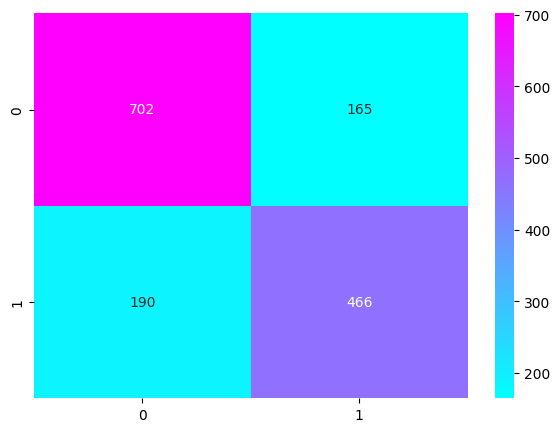

In [32]:
plt.figure(figsize=(7, 5))
sns.heatmap(conm, annot=True, fmt='d', cmap='cool')
plt.show()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       867
           1       0.74      0.71      0.72       656

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



#### Run hyperparameter tuning

Run model with bigger lstm out


In [34]:
embed_dim = 64
lstm_out = 64
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.4))
model.add(Dense(1, activation = 'sigmoid'))
adam = optimizers.Adam(learning_rate =0.002)
model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))
y_pred = model.predict(X_test).round()
train_accuracy = round(metrics.accuracy_score(y_train,model.predict(X_train).round())*100)
print('Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test, y_pred)))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 24, 64)            192000    
                                                                 
 dropout_1 (Dropout)         (None, 24, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 225089 (879.25 KB)
Trainable params: 225089 (879.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
191/191 [==============================] - 15s 57ms/step - loss: 0.5369 - accuracy: 0.7233 - val_loss: 0.4449 - val_accuracy: 0.80

We can see that the model with bigger lstm out has lower performance.
So I will run model with the previous lstm out and different learning rate
* Learning rate = 0.0001

In [40]:
embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.4))
model.add(Dense(1, activation = 'sigmoid'))
adam = optimizers.Adam(learning_rate =0.002)
model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(lr=0.0001), metrics = ['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))
y_pred = model.predict(X_test).round()
train_accuracy = round(metrics.accuracy_score(y_train,model.predict(X_train).round())*100)
print('Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test, y_pred)))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 24, 32)            96000     
                                                                 
 dropout_2 (Dropout)         (None, 24, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 104353 (407.63 KB)
Trainable params: 104353 (407.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
191/191 [==============================] - 15s 52ms/step - loss: 0.6185 - accuracy: 0.6596 - val_loss: 0.4977 - val_accuracy: 0.78

We have the same accuracy with the the original model, so we also use it to predict test data.

## 5. Conclusion

To summarize: After running the first model, we achieved an accuracy of 0.76, which is very good. Then we ran another model with a larger LSTM output, which gave us a lower result. After that, we tried changing to a model with a smaller learning rate, which yielded the same accuracy. So, we decided to use the original model to predict the test data.


In [35]:
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [36]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [37]:
test_token = tokenizer.texts_to_sequences(test_data['text'].values)
test_token = pad_sequences(test_token)

In [38]:
y_hat = model.predict(test_token).round()


102/102 [==============================] - 1s 6ms/step


In [39]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('submission9.csv', index=False)
submission.describe().style.background_gradient(cmap='coolwarm')

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.474717
std,3146.427221,0.499437
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000
